In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('time-series-prediction-testcases\input\input01.txt','r') as file:
    text = [int(number.rstrip()) for number in file.readlines()]

In [3]:
text.pop(0)

500

In [4]:
import pandas as pd

In [5]:
dates = pd.date_range(start='2012-10-1', periods=500)

In [6]:
df = pd.DataFrame(data=text, index=dates, columns=['sessions'])

In [7]:
df.head()

,sessions
2012-10-01,1339
2012-10-02,1462
2012-10-03,1702
2012-10-04,1656
2012-10-05,1439


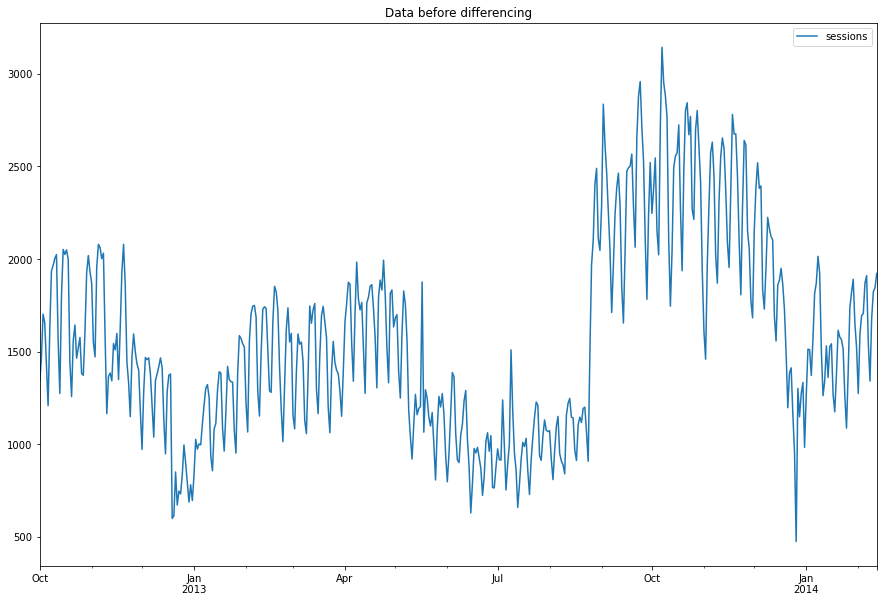

In [8]:
df.plot(figsize=(15,10))
plt.title('Data before differencing')
plt.show()

In [9]:
diff = df.diff(periods=7)
diff = diff.diff()

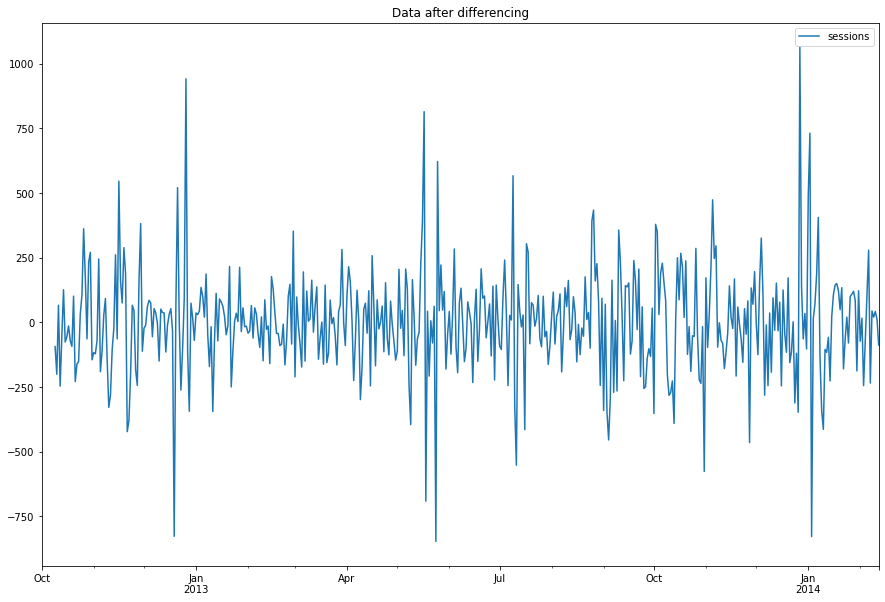

In [10]:
diff.plot(figsize=(15,10))
plt.title('Data after differencing')
plt.show()

In [11]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [12]:
diff

,sessions
2012-10-01,NaN
2012-10-02,NaN
2012-10-03,NaN
2012-10-04,NaN
2012-10-05,NaN
...,...
2014-02-08,44.0
2014-02-09,20.0
2014-02-10,42.0
2014-02-11,11.0


In [13]:
diff = diff.iloc[8:]

In [14]:
diff

,sessions
2012-10-09,-94.0
2012-10-10,-201.0
2012-10-11,66.0
2012-10-12,-247.0
2012-10-13,-54.0
...,...
2014-02-08,44.0
2014-02-09,20.0
2014-02-10,42.0
2014-02-11,11.0


In [15]:
x = np.arange(1,101)

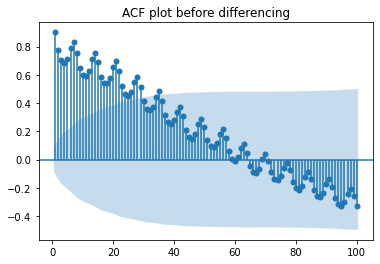

In [16]:
plot_acf(df,lags=x, use_vlines=True, title='ACF plot before differencing')
plt.show()

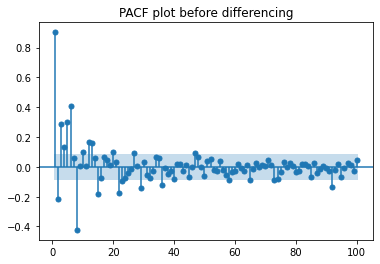

In [17]:
plot_pacf(df,lags=x, title='PACF plot before differencing')
plt.show()

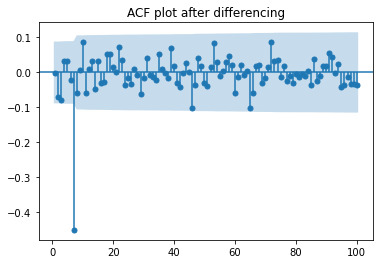

In [18]:
plot_acf(diff,lags=x, title='ACF plot after differencing')
plt.show()

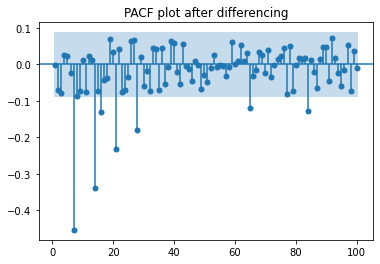

In [19]:
plot_pacf(diff, lags=x, title='PACF plot after differencing')
plt.show()

ARIMA(0,1,0)(0,1,1)7

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [21]:
order = (0,1,0)
seasonal_order = (0,1,1,7)

In [22]:
model = SARIMAX(diff, order=order,seasonal_order=seasonal_order).fit()

C:\Users\henri\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            sessions   No. Observations:                  492
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -3442.693
Date:                             Mon, 04 Jan 2021   AIC                           6889.387
Time:                                     15:55:12   BIC                           6897.751
Sample:                                 10-09-2012   HQIC                          6892.674
                                      - 02-12-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.9997      3.195     -0.313      0.754      -7.261       5.262
sigma2      8.313e+04   2.66e+05      0.313      0.754   -4.38e+05    6.04e+05
===================================================================================
Ljung-Box (L1) (Q):                 105.76   Jarque-Bera (JB):               714.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -0.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
res = model.resid

In [25]:
x = np.arange(1,101)

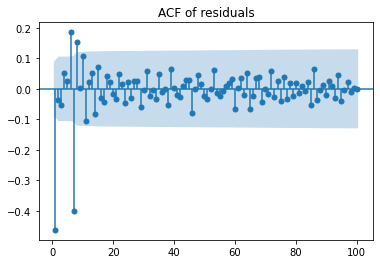

In [26]:
plot_acf(res, lags=x, title='ACF of residuals')
plt.show()

C:\Users\henri\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


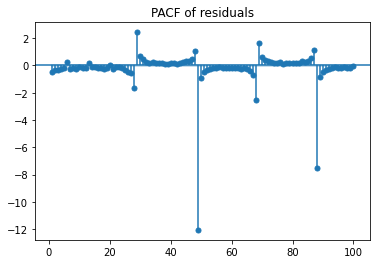

In [27]:
plot_pacf(res, lags=x, title='PACF of residuals')
plt.show()

In [28]:
yhat = model.forecast(30)

In [29]:
yhat

2014-02-13   -85.674325
2014-02-14   -89.042500
2014-02-15   -86.516593
2014-02-16   -87.872008
2014-02-17   -89.456143
2014-02-18   -87.121335
2014-02-19   -88.007460
2014-02-20   -85.681785
2014-02-21   -89.049960
2014-02-22   -86.524053
2014-02-23   -87.879468
2014-02-24   -89.463603
2014-02-25   -87.128795
2014-02-26   -88.014920
2014-02-27   -85.689245
2014-02-28   -89.057420
2014-03-01   -86.531513
2014-03-02   -87.886928
2014-03-03   -89.471063
2014-03-04   -87.136255
2014-03-05   -88.022380
2014-03-06   -85.696705
2014-03-07   -89.064880
2014-03-08   -86.538973
2014-03-09   -87.894388
2014-03-10   -89.478523
2014-03-11   -87.143715
2014-03-12   -88.029840
2014-03-13   -85.704165
2014-03-14   -89.072340
Freq: D, Name: predicted_mean, dtype: float64

In [30]:
with open('time-series-prediction-testcases\output\output01.txt','r') as file:
    test = [int(number.rstrip()) for number in file.readlines()]

In [31]:
dates_test = pd.date_range(start='2014-02-13', periods=30)

In [32]:
df_test = pd.DataFrame(data=test, index=dates_test, columns=['real'])

In [33]:
df_test['predicted'] = yhat

In [34]:
df_test

,real,predicted
2014-02-13,1808,-85.674325
2014-02-14,1454,-89.042500
2014-02-15,1393,-86.516593
2014-02-16,1733,-87.872008
2014-02-17,1944,-89.456143
2014-02-18,1911,-87.121335
2014-02-19,1804,-88.007460
2014-02-20,1525,-85.681785
2014-02-21,573,-89.049960
2014-02-22,576,-86.524053


In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [36]:
mse = mean_squared_error(df_test['real'].tolist(),yhat.tolist())
rmse = sqrt(mse)

In [37]:
rmse

1134.7443241783064

In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
mean_absolute_percentage_error(df_test['real'].tolist(), yhat.tolist())

111.14501605403784

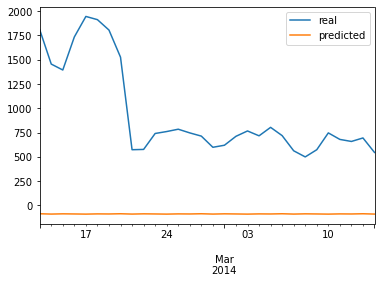

In [41]:
df_test.plot()
plt.show()